In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

So fair warning: the clusters do not look like they are supposed to. TBH even the cell counts before preprocessing are not right and I'm not sure why? I'm really sorry for this mess!

In [2]:
# Read scRNA-seq data for stroke
stroke = sc.read_10x_mtx("/home/escatay/Coxi/Neurogenomics/Project/Data/Guo_et_al/GSE167593/", prefix = 'GSE167593_') #change path
stroke.var_names_make_unique()
stroke.obs['study'] = 'stroke'

stroke.obs['condition'] = 'WT_sc'
condition_column = stroke.obs['condition']
# Update condition to 'WT_st' where index contains '-1'
condition_column.loc[condition_column.index.str.contains('-3')] = 'HS'
condition_column.loc[condition_column.index.str.contains('-2')] = 'IS'

# Assign the updated column back to AnnData object
stroke.obs['condition'] = condition_column
#AD data
#single nucleus
wt_sn = sc.read_10x_mtx("/home/escatay/Coxi/Neurogenomics/Project/Data/Guo_et_al/GSE140399_RAW/GSM4160643_WT_Cor/", gex_only = True, prefix = 'GSM4160643_WT_Cor_') #change path
wt_sn.var_names_make_unique()
wt_sn.obs['study'] = 'WT_sn'
wt_sn.obs['condition'] = 'WT_sn'
#AD phenotype
ad_cor = sc.read_10x_mtx("/home/escatay/Coxi/Neurogenomics/Project/Data/Guo_et_al/GSE140399_RAW/GSM4160645_WT_5XFAD/", gex_only = True, prefix = 'GSM4160645_WT_5XFAD_Cor_') #change path
ad_cor.var_names_make_unique()
ad_cor.obs['study'] = 'ad_cor'
ad_cor.obs['condition'] = 'ad_cor'

In [3]:
#merge datasets
ad_stroke0 = sc.AnnData.concatenate(stroke, wt_sn, ad_cor, join='outer', batch_key='study')
#print(ad_stroke0.obs['condition'].value_counts())

/home/escatay/anaconda3/envs/neugen/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


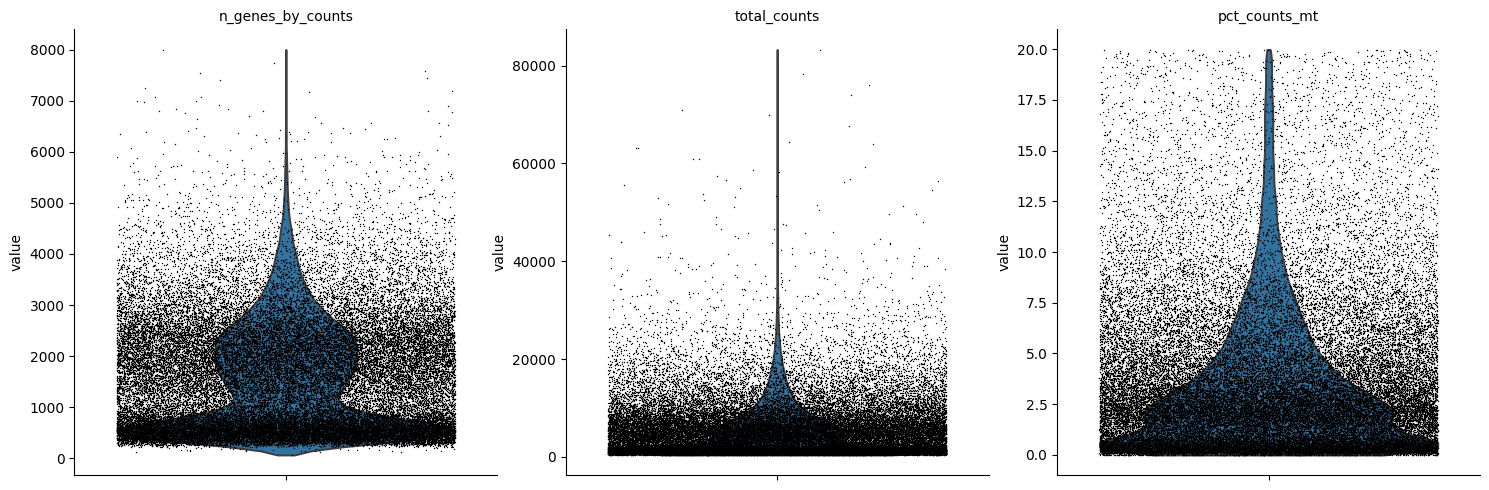

In [4]:
# Filter out cells with UMI count below 200
sc.pp.filter_cells(ad_stroke0, min_counts = 200)
# Filter out mitochondrial gene expression > 20%
# Calculate mitochondrial gene expression ratio for each cell
ad_stroke0.var["mt"] = ad_stroke0.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(ad_stroke0, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
ad_stroke0.obs['outlier_mt'] = ad_stroke0.obs.pct_counts_mt >= 20
ad_stroke0 = ad_stroke0[~ad_stroke0.obs['outlier_mt'], :]
#filter out genes in less than 3 cells
ad_stroke = ad_stroke0.copy()
sc.pp.filter_genes(ad_stroke, min_cells=3)
#verify cell counts
#print(ad_stroke.obs['condition'].value_counts())
#to consider where to cut off genes:
sc.pl.violin(ad_stroke, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

In [5]:
"""#out of desperation  I tried to cut off the very highly expressed genes too
#but it did not exactly improve results
ad_stroke.obs['outlier_total'] = ad_stroke.obs.total_counts > 3000
ad_stroke.obs['outlier_ngenes'] = ad_stroke.obs.n_genes_by_counts > 4500
ad_stroke= ad_stroke[~ad_stroke.obs['outlier_total'], :]
ad_stroke = ad_stroke[~ad_stroke.obs['outlier_ngenes'], :]"""

"#out of desperation  I tried to cut off the very highly expressed genes too\n#but it did not exactly improve results\nad_stroke.obs['outlier_total'] = ad_stroke.obs.total_counts > 3000\nad_stroke.obs['outlier_ngenes'] = ad_stroke.obs.n_genes_by_counts > 4500\nad_stroke= ad_stroke[~ad_stroke.obs['outlier_total'], :]\nad_stroke = ad_stroke[~ad_stroke.obs['outlier_ngenes'], :]"

In [6]:
# Define the dictionary-like structure in Python
neuronal_cell_types_dict = {
    "Astrocyte": ["Aqp4", "Gja1"],
    "Endothelial_cell": ["Cldn5", "Flt1"],
    "Excitatory_neurons": ["Cck", "Camk2a", "Atp1a1"],
    "Microglia": ["P2ry12", "Tmem119"],
    "Neuroblast": ["Dcx"],
    "Neutrophil": ["S100a8"],
    "Oligodendrocyte": ["Mbp", "Plp1"],
    "OPCs": ["Pdgfra", "Vcan"],
    "T_cells": ["Cd3e"]
}

# Loop through cell types and add module scores
for cell_type, genes in neuronal_cell_types_dict.items():
    gene_indices = [np.where(ad_stroke.var_names == gene)[0][0] for gene in genes]
    ad_stroke.obs[f'score_{cell_type}'] = ad_stroke.X[:, gene_indices].sum(axis=1)
# Extract scores
scores = ad_stroke.obs.filter(like="score")

# Predict cell types based on module scores
ad_stroke.obs['predicted_cell_type'] = scores.idxmax(axis=1)

This is supposed to be similar to SCTransorm, which is why I used it. However, it expects the rwa UMI counts so no normalisation beforehand. I also tried to just normalise, log1p and regressing out based on variable features and the clusters did not look much different. so yeah idk

In [7]:
sc.experimental.pp.highly_variable_genes(ad_stroke, flavor= 'pearson_residuals' , n_top_genes=3000, batch_key = 'study')
ad_stroke= ad_stroke[:, ad_stroke.var["highly_variable"]]
#keep raw and depth-normalized counts for later
ad_stroke.layers["raw"] = ad_stroke.X.copy()
sc.experimental.pp.normalize_pearson_residuals(ad_stroke)
sc.pp.scale(ad_stroke)

In [ ]:
sc.pp.pca(ad_stroke, n_comps=30)
#Run Harmony batch correction
sc.external.pp.harmony_integrate(ad_stroke, key='study', plot_convergence = True)
sc.pp.neighbors(ad_stroke, n_neighbors=20, n_pcs=30)
sc.tl.leiden(ad_stroke, resolution = 0.4)
sc.tl.umap(ad_stroke, min_dist=0.3, spread=1.0, n_components=30, random_state = 42)

2024-02-16 01:11:36,404 - harmonypy - INFO - Iteration 1 of 10
2024-02-16 01:11:48,422 - harmonypy - INFO - Iteration 2 of 10
2024-02-16 01:12:00,482 - harmonypy - INFO - Converged after 2 iterations


So I feel like with a bit of imagination the clusters have some resemblance with the ones from the paper but they're clearly not of the same quality. Also the cell counts after filtering (unsurprisngly) also don't match.

In [ ]:
# Plot UMAP visualizations
sc.pl.umap(ad_stroke, color = 'predicted_cell_type')
sc.pl.umap(ad_stroke, color = 'condition')

# Print summary statistics
print(ad_stroke.obs['condition'].value_counts())


In [ ]:
# Check metadata associated with observations (cells)
print("Observations metadata:")
print(ad_stroke.obs)

# Check metadata associated with variables (genes)
print("\nVariables metadata:")
print(ad_stroke.var)